Number of Readings: 97


<IPython.core.display.Javascript object>


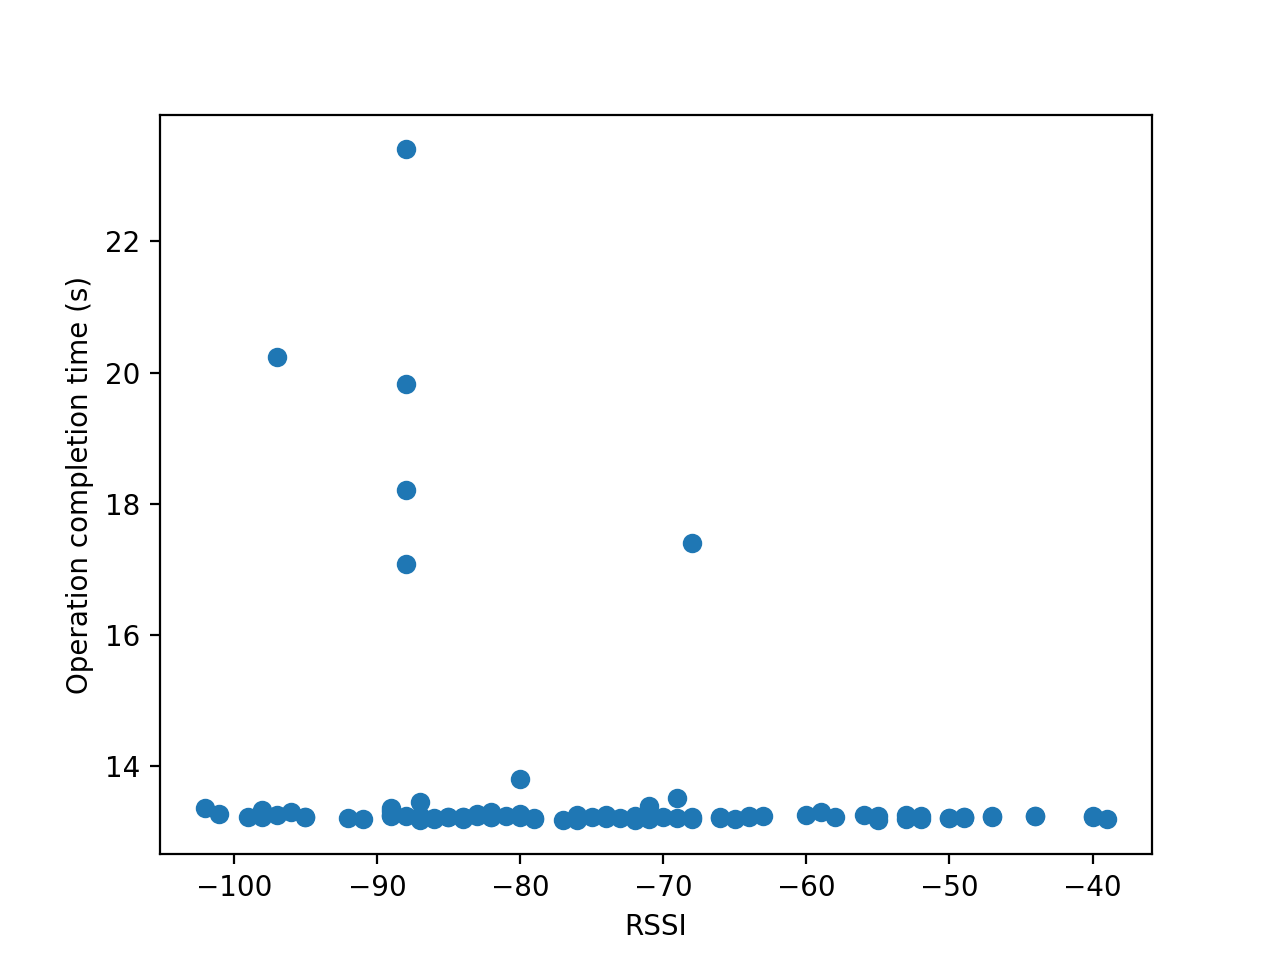

Mean loading time: 13.6238925567
Loading time std_dev: 1.56838761755
Mean RSSI: -74.3711340206
RSSI std_dev: 16.0072918871
R squared value : 0.0419418167215


In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


# The goal of this scriptis twofold: parse files and then visualize the output

# Class that just holds the network stats corresponding to a load time
class DataPoint:
    def __init__(self, _rsrp, _rsrq, _sinr, _rssi, _load_time):
        self.rsrp = _rsrp
        self.rsrq = _rsrq
        self.sinr = _sinr
        self.rssi = _rssi
        self.load_time = _load_time

# name of the file to open
# Files from the long drive were drive_to_mullholland.txt, drive_home.txt, and full_drive.txt
# Other files usable are the upload_walking* files
# This isn't yet tested on the walking files
FILENAME = 'full_drive.txt'

input_file = open(FILENAME, 'r')

# The timer for drive_home and drive_to_mullholland was broken because I didn't reset it
# in between runs. You can still get accurate times it just takes a little more work
last_timestamp = 0
# drive_home starts partway through a trip, so we need to change the initial timer value
if FILENAME == 'drive_home.txt':
    last_timestamp = 989.480591

# Initialize
current_rsrp = 0
current_rsrq = 0
current_sinr = 0
current_rssi = 0

all_datapoints = []


# Go through each line in the log
for line in (input_file):
    
    #Once we see a loading time, we know we are at the end of an operation, create and save the datapoint
    if 'loading time: ' in line:
        #strip out the loading time and make a 
        load_time_string = line.split("loading time: ",1)[1] 
        load_timestamp = float(load_time_string)
        # Comment out "-last_timestamp" if not using one of the broken logs (From drive)
        load_time = load_timestamp  - last_timestamp
        new_datapoint = DataPoint(current_rsrp, current_rsrq,
            current_sinr, current_rssi, load_time)
        all_datapoints.append(new_datapoint)
        last_timestamp = load_timestamp

    elif 'AT%MEAS=' in line and 'Signal Quality' in line:
        # this means that this line is an AT%MEAS response
        
        # Strip out the entire beginning of the line
        line = line.split("AT%MEAS=\"8\"",1)[1] 
        
        # At this point, we have a comma separated list of returned values
        
        data_strings = line.split(',')
        # We should now have the following format
        # [Signal Quality: RSRP = N/A, RSRQ = N/A, SINR = N/A, RSSI = N/AOK]
        
        for section in data_strings:
            if "RSSI = " in section:
                rssi_string_raw = section.split("RSSI = ",1)[1] 
                
                # pull off the last space and the letters "OK"
                refined_rssi_string = rssi_string_raw[:-3]
                
                # One of the logs crashed and had 'N/A' returned, ignore that
                if (refined_rssi_string != 'N/A'):
                    current_rssi = int(refined_rssi_string)
            elif "RSRP = " in section:
                # Here raw is good enough to parse
                rsrp_string_raw = section.split("RSRP = ",1)[1]
                if (rsrp_string_raw != 'N/A'):
                    current_rsrp = int(rsrp_string_raw)
            elif "RSRQ = " in section:
                # Here raw is good enough to parse
                rsrq_string_raw = section.split("RSRQ = ",1)[1]
                if (rsrq_string_raw != 'N/A'):
                    current_rsrq = int(rsrq_string_raw)
            elif "SINR = " in section:
                # Here raw is good enough to parse
                sinr_string_raw = section.split("SINR = ",1)[1]
                if (sinr_string_raw != 'N/A'):
                    current_sinr = int(sinr_string_raw)

print('Number of Readings: ' + str(len(all_datapoints)))

# Get the data ready to plot
all_load_times = []
all_rssi_values = []
all_rsrp_values = []
all_sinr_values = []
all_rsrq_values = []
for x in all_datapoints:
    all_load_times.append(x.load_time)
    all_rssi_values.append(x.rssi)
    all_rsrp_values.append(x.rsrp)
    all_sinr_values.append(x.sinr)
    all_rsrq_values.append(x.rsrq)

# Plotting
plt.scatter(all_rssi_values, all_load_times)
#plt.plot(all_rssi_values)
plt.ylabel('Operation completion time (s)')
plt.xlabel('RSSI')

# Stats on loading time
std_dev_load_time = np.std(all_load_times)
mean_load_time = np.mean(all_load_times)
print('Mean loading time: ' + str(mean_load_time))
print('Loading time std_dev: ' + str(std_dev_load_time))

# Stats on RSSI
std_dev_rssi = np.std(all_rssi_values)
mean_rssi = np.mean(all_rssi_values)
print('Mean RSSI: ' + str(mean_rssi))
print('RSSI std_dev: ' + str(std_dev_rssi))


# Attempting to plot a line of best fit for the rssi vs load time
z = np.polyfit(all_rssi_values, all_load_times, 1)
p = np.poly1d(z)
# plt.plot(all_rssi_values,p(all_rssi_values),"r--")


# r squared value, taken from stack overflow
yhat = p(all_rssi_values)                         # or [p(z) for z in x]
ybar = np.sum(all_load_times) / len(all_load_times)          # or sum(y)/len(y)
ssreg = np.sum((yhat - ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((all_load_times - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
print('R squared value : ' + str(ssreg / sstot))